# Flux pumping
Gengyan Zhang, September 7 2016

When the qubit frequency $\omega_q$ and cavity frequency $\omega_r$ are detuned from each other, an effective resonant interaction can be generated by modulating the qubit frequency at $\omega_r-\omega_q$.
## Reference
[Strand JD, Ware M, Beaudoin F, Ohki TA, Johnson BR, Blais A, et al. First-order sideband transitions with flux-driven asymmetric transmon qubits. Physical Review B  **87**, 220505 (2013).](http://link.aps.org/doi/10.1103/PhysRevB.87.220505)

QuTiP examples:
[Quasi-steadystate of time-dependent (periodic) systems](http://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/example-quasi-steadystate-driven-system.ipynb), 
[Floquet formalism](http://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/example-floquet-dynamics.ipynb).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from IPython.display import display, Markdown
plt.rc('font', size=16)

## Parameters

In [2]:
Nmax = 5
omegaR = 8e9*2*np.pi
omegaQ = 7.6e9*2*np.pi
g = 129e6*2*np.pi
kappa = 0.37e6
gamma = 1/10e-6

## Operators

In [3]:
a = qt.tensor(qt.destroy(Nmax), qt.qeye(2))
adag = a.dag()
sx = qt.tensor(qt.qeye(Nmax), qt.sigmax())
sy = qt.tensor(qt.qeye(Nmax), qt.sigmay())
sz = qt.tensor(qt.qeye(Nmax), qt.sigmaz())
sp = qt.tensor(qt.qeye(Nmax), qt.sigmap())
sm = qt.tensor(qt.qeye(Nmax), qt.sigmam())

## Hamiltonian
In the rotating frame of bare qubit frequency,
$$H_0 = (\omega_r-\omega_q)a^\dagger a+g(a^\dagger\sigma_-+a\sigma_+)$$

In [4]:
H0 = (omegaR-omegaQ)*adag*a + g*(adag*sm + a*sp)

## Dressed states, frequencies and operators
The dressed states and their frequencies can be calculated by diagonalizing the Hamiltonian:

In [5]:
eigvals, eigvecs = H0.eigenstates()
print('Eigen eneriges (in MHz) of dressed states:')
for ii in range(0, 6):
    print(eigvals[ii]/(2*np.pi)/1e6)

Eigen eneriges (in MHz) of dressed states:
-37.9936973955
0.0
329.293516886
437.993697396
700.128360794
870.706483114


So the dressed frequencies are $E_{|e0\rangle}$ = -37.99 MHz, $E_{|g0\rangle}$ = 0, $E_{|e1\rangle}$ = 329.29 MHz, $E_{|g1\rangle}$ = 437.99 MHz, ...  
We can construct the dressed Pauli and ladder operators from the eigenstates:

In [6]:
szD = 0*qt.tensor(qt.qeye(Nmax), qt.qeye(2))
nD = 0*qt.tensor(qt.qeye(Nmax), qt.qeye(2))
for ii in np.arange(0, len(eigvecs), 2):
    # Dressed |e, n=ii/2> state
    psiE = eigvecs[ii].unit()
    # Dressed |g, n=ii/2> state
    psiG = eigvecs[ii+1].unit()
    # Dressed sigmaz operator
    szD = szD + psiE*psiE.dag() - psiG*psiG.dag()
    # Dressed photon number operator
    nD = nD + ii/2*(psiE*psiE.dag() + psiG*psiG.dag())

## Apply modulation to qubit frequency
Hamiltonian $H(t) = H_0+A_p\sigma_z\sin(\omega_p t),$

where $\omega_p$ is the pump frequency and $A_p$ is the pump amplitude.

In [7]:
def fluxPump(omegaP, ampP, psi0, tlist):
    # omegaP: flux pump frequency
    # ampP: flux pump amplitude
    # psi0: initial state
    # tlist: time axis
    # Returns: expectation value of dressed sigmaz and adag*a for each time step
    
    # Time dependent Hamiltonian: H(t) = H0 + amp*sin(omega*t)
    Ht = [H0, [ampP*sz, lambda t, args:np.sin(args['omegaP']*t)]]
    result = qt.mesolve(Ht, psi0, tlist,
                        c_ops=[np.sqrt(kappa)*a, np.sqrt(gamma)*sm],
                        e_ops=[szD, nD], args={'omegaP': omegaP})
    return np.real(result.expect[0]), np.real(result.expect[1])

# Initial state
psi0 = eigvecs[0]
# Time axis
tlist = np.linspace(0, 200e-9, 1001)
# Sweep modulation frequency
omegaPlist = np.linspace(435e6, 515e6, 21)*2*np.pi
# Modulation amplitude
ampP = 50e6*2*np.pi

print('Solving master equation ...')
result = qt.parallel_map(fluxPump, omegaPlist, task_args=(ampP, psi0, tlist),
                         progress_bar=True)
szarray = np.array([r[0] for r in result]).T
narray = np.array([r[1] for r in result]).T

# Pick the modulation frequency as the difference between (dressed) cavity and qubit
omegaP = (eigvals[3]-eigvals[0])
szlist, nlist = fluxPump(omegaP, ampP, psi0, tlist)

Solving master equation ...
14.3%. Run time:  13.51s. Est. time left: 00:00:01:21
23.8%. Run time:  25.73s. Est. time left: 00:00:01:22
33.3%. Run time:  28.24s. Est. time left: 00:00:00:56
42.9%. Run time:  40.61s. Est. time left: 00:00:00:54
52.4%. Run time:  41.76s. Est. time left: 00:00:00:37
61.9%. Run time:  54.37s. Est. time left: 00:00:00:33
71.4%. Run time:  55.97s. Est. time left: 00:00:00:22
81.0%. Run time:  68.51s. Est. time left: 00:00:00:16
90.5%. Run time:  69.75s. Est. time left: 00:00:00:07
100.0%. Run time:  75.47s. Est. time left: 00:00:00:00
Total run time:  75.52s


## Rabi oscillations

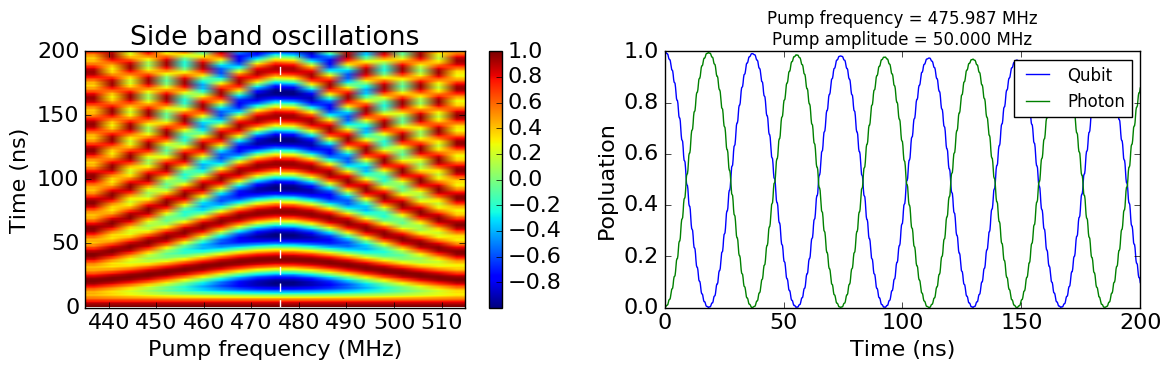

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(szarray, extent=[omegaPlist[0]/(2*np.pi)/1e6, omegaPlist[-1]/(2*np.pi)/1e6,
                            tlist[0]/1e-9, tlist[-1]/1e-9],
           origin='lower', aspect=0.5)
plt.colorbar()
plt.plot([omegaP/(2*np.pi)/1e6, omegaP/(2*np.pi)/1e6], [tlist[0]/1e-9, tlist[-1]/1e-9], 'w--')
plt.axis('tight')
plt.xlabel('Pump frequency (MHz)')
plt.ylabel('Time (ns)')
plt.title('Side band oscillations')

plt.subplot(122)
plt.plot(tlist/1e-9, (szlist+1)/2, tlist/1e-9, nlist)
plt.xlabel('Time (ns)')
plt.ylabel('Popluation')
plt.legend(['Qubit', 'Photon'], fontsize=12)
plt.title('Pump frequency = %.3f MHz\nPump amplitude = %.3f MHz' % (omegaP/(2*np.pi)/1e6, ampP/(2*np.pi)/1e6),
          fontsize=12)

plt.tight_layout()
plt.show()

We get the expected chevron pattern (see fig. 3 in ref). The coupling is maximized when the modulation frequency matches the energy difference between the (dressed) qubit and cavity, which is $E_{|g1\rangle}-E_{|e0\rangle}$ = 475.99 MHz (white dashed line in left figure).

## Cavity transmission
To calculate cavity transmission in the presence of flux pumping, we need to calculate the propagator for one pump period ($T=2\pi/\omega_p$) and then find the (quasi) steady state for successive applications of the propagator.

Hamiltonian $H(t) = (\omega_r-\omega_d)a^\dagger a+(\omega_q-\omega_d)\frac{\sigma_z}{2}+g(a^\dagger\sigma_-+a\sigma_+)+A_d(a+a^\dagger)+A_p\sigma_z\sin(\omega_p t),$

where $(\omega_d, A_d)$ is the cavity drive (frequency, amplitude), $(\omega_p, A_p)$ is the flux pump (frequency, amplitude).

In [9]:
def transmission(omega, ampD, ampP):
    # omega[0]: cavity drive frequency
    # omega[1]: flux pump frequency
    # ampD: cavity drive amplitude
    # ampP: flux pump frequency
    # Returns: expectation value of adag*a of the steady state
    omegaD = omega[0]
    omegaP = omega[1]
    
    Ht = [(omegaR-omegaD)*adag*a + (omegaQ-omegaD)/2*sz + g*(adag*sm + a*sp) + ampD*(a+adag),
          [ampP*sz, lambda t, args: np.sin(args['omegaP']*t)]]
    # Calculate propagator for one pump period T = 2pi/omegaP
    U = qt.propagator(H=Ht, t=2*np.pi/omegaP,
                      c_op_list=[np.sqrt(kappa)*a, np.sqrt(gamma)*sm],
                      args={'omegaP': omegaP})
    # Calucate steady state density matrix
    rhoss = qt.propagator_steadystate(U)
    # Return photon number for steady state
    return np.real(qt.expect(adag*a, rhoss))

In [10]:
# Dressed qubit frequency
omegaQD = (omegaQ/2+eigvals[0]) - (-omegaQ/2+eigvals[1])
# Dressed cavity frequency
omegaRD = (omegaQ/2+eigvals[3]) - (-omegaQ/2+eigvals[1])
# Dressed cavity-qubit detuning
deltaD = omegaRD-omegaQD

omegaDlist = np.linspace(omegaRD-2e6*2*np.pi, omegaRD+2e6*2*np.pi, 81)
omegaP = deltaD
ampD = 0.5*kappa
ampP = 4e6*2*np.pi

print('Parameters:')
print('Bare cavity frequency: %.3f GHz' % (omegaR/(2*np.pi)/1e9))
print('Bare qubit frequency: %.3f GHz' % (omegaQ/(2*np.pi)/1e9))
print('Dressed cavity frequency: %.3f GHz' % (omegaRD/(2*np.pi)/1e9))
print('Dressed qubit frequency: %.3f GHz' % (omegaQD/(2*np.pi)/1e9))
print('Flux pump frequency: %.3f MHz' % (omegaP/(2*np.pi)/1e6))
print('Flux pump amplitude: %.3f MHz' % (ampP/(2*np.pi)/1e6))

# Construct a list of all combinations of omegaD and omegaP for parallelization
omegazip = list(zip(omegaDlist, np.repeat(omegaP, len(omegaDlist))))
# Compute steady state
print('\nSolve for steady state ...')
transdata = qt.parallel_map(transmission, omegazip, task_args=(ampD, ampP), progress_bar=True)

Parameters:
Bare cavity frequency: 8.000 GHz
Bare qubit frequency: 7.600 GHz
Dressed cavity frequency: 8.038 GHz
Dressed qubit frequency: 7.562 GHz
Flux pump frequency: 475.987 MHz
Flux pump amplitude: 4.000 MHz

Solve for steady state ...
11.1%. Run time:  66.65s. Est. time left: 00:00:08:53
21.0%. Run time: 109.32s. Est. time left: 00:00:06:51
30.9%. Run time: 152.26s. Est. time left: 00:00:05:41
40.7%. Run time: 197.98s. Est. time left: 00:00:04:47
50.6%. Run time: 238.99s. Est. time left: 00:00:03:53
60.5%. Run time: 278.27s. Est. time left: 00:00:03:01
70.4%. Run time: 317.41s. Est. time left: 00:00:02:13
80.2%. Run time: 357.43s. Est. time left: 00:00:01:27
90.1%. Run time: 395.04s. Est. time left: 00:00:00:43
100.0%. Run time: 424.34s. Est. time left: 00:00:00:00
Total run time: 424.37s


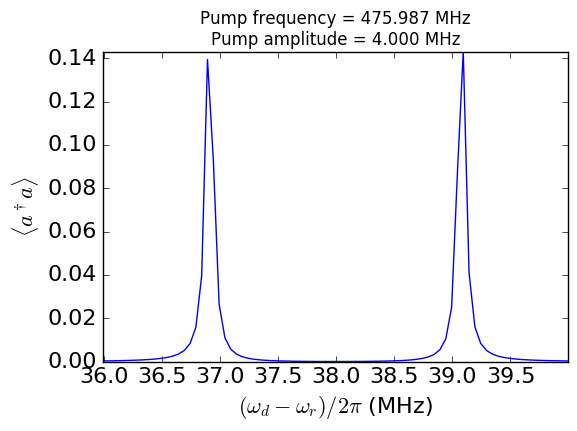

In [11]:
plt.figure()
plt.plot((omegaDlist-omegaR)/(2*np.pi)/1e6, transdata)
plt.axis('tight')
plt.xlabel(r'$(\omega_d-\omega_r)/2\pi$ (MHz)')
plt.ylabel(r'$\langle a^\dagger a\rangle$')
plt.title('Pump frequency = %.3f MHz\nPump amplitude = %.3f MHz' % (omegaP/(2*np.pi)/1e6, ampP/(2*np.pi)/1e6),
          fontsize=12)
plt.show()

We can see the avoided crossing induced by the flux pumping in cavity transmission.

Below is a (very time consuming) calculation of the cavity transmission vs pump frequency. The python script is [transSweep.py](./transSweep.py) and data is saved in [transSweep.dat](./transSweep.dat).

In [12]:
# %run 'transSweep.py'

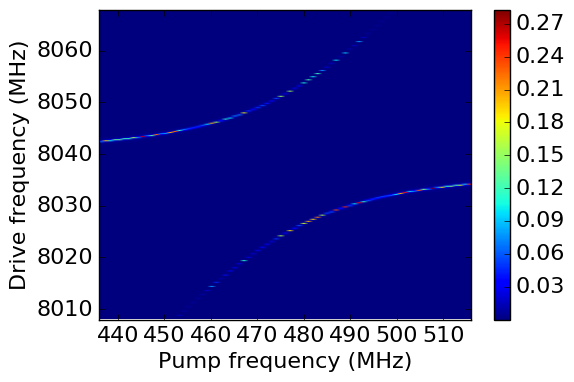

In [13]:
data = qt.file_data_read('transSweep.dat')
omegaDlist = data[0, 1:]
omegaPlist = data[1:, 0]
transarray = data[1:, 1:]
omegaP = omegaPlist[len(omegaPlist)//2]

plt.figure()
plt.imshow(transarray.T, extent=[omegaPlist[0]/(2*np.pi)/1e6, omegaPlist[-1]/(2*np.pi)/1e6,
                                 omegaDlist[0]/(2*np.pi)/1e6, omegaDlist[-1]/(2*np.pi)/1e6],
           origin='lower')
plt.colorbar()
plt.axis('tight')
plt.xlabel('Pump frequency (MHz)')
plt.ylabel('Drive frequency (MHz)')
plt.show()

## Floquet quasi energy levels
The above avoided crossing is related to the quasi energy levels in Floquet formalism.

Calculate Floquet quasi energy ...
11.1%. Run time:   3.69s. Est. time left: 00:00:00:29
21.0%. Run time:   5.97s. Est. time left: 00:00:00:22
30.9%. Run time:   8.59s. Est. time left: 00:00:00:19
40.7%. Run time:  10.89s. Est. time left: 00:00:00:15
50.6%. Run time:  13.14s. Est. time left: 00:00:00:12
60.5%. Run time:  15.54s. Est. time left: 00:00:00:10
70.4%. Run time:  17.83s. Est. time left: 00:00:00:07
80.2%. Run time:  20.03s. Est. time left: 00:00:00:04
90.1%. Run time:  22.18s. Est. time left: 00:00:00:02
100.0%. Run time:  23.92s. Est. time left: 00:00:00:00
Total run time:  23.95s


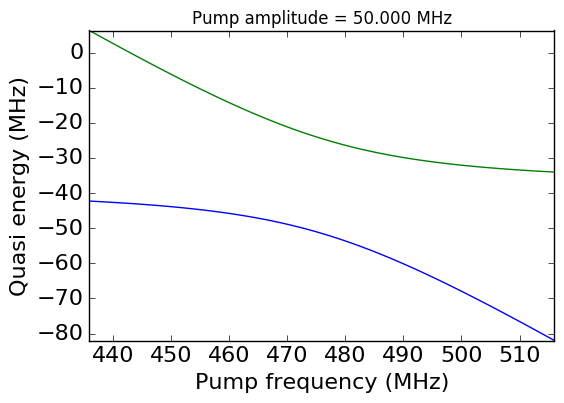

In [14]:
def floqlevels(omegaP, ampP):
    Ht = [H0, [ampP*sz, lambda t, args: np.sin(args['omegaP']*t)]]
    flovecs, flovals = qt.floquet_modes(Ht, T=2*np.pi/omegaP, args={'omegaP': omegaP})
    return flovals[0:2]

omegaPlist = np.linspace(deltaD-40e6*(2*np.pi), deltaD+40e6*(2*np.pi), 81)
ampP = 50e6*2*np.pi
print('Calculate Floquet quasi energy ...')
result = qt.parallel_map(floqlevels, omegaPlist, task_args=(ampP,), progress_bar=True)
floqlv0 = np.min(np.array(result), axis=1)
floqlv1 = np.max(np.array(result), axis=1)

plt.figure()
plt.plot(omegaPlist/(2*np.pi)/1e6, floqlv0/(2*np.pi)/1e6)
plt.plot(omegaPlist/(2*np.pi)/1e6, floqlv1/(2*np.pi)/1e6)
plt.axis('tight')
plt.xlabel('Pump frequency (MHz)')
plt.ylabel('Quasi energy (MHz)')
plt.title('Pump amplitude = %.3f MHz' % (ampP/(2*np.pi)/1e6), fontsize=12)
plt.show()

In [15]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,3.2.0.dev-88e1862
Numpy,1.11.1
SciPy,0.18.0
matplotlib,1.5.1
Cython,0.24.1
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"3.5.2 |Continuum Analytics, Inc.| (default, Jul 2 2016, 17:53:06) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
